In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import yaml
import logging
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../')

from abacus.auto_ab.abtest import ABTest
from abacus.auto_ab.params import ABTestParams
from abacus.auto_ab.params import DataParams, HypothesisParams
from abacus.splitter.split_builder import SplitBuilder
from abacus.splitter.params import SplitBuilderParams
from abacus.mde_researcher.params import MdeParams
from abacus.mde_researcher.mde_research_builder import MdeResearchBuilder
from abacus.mde_researcher.multiple_split_builder import MultipleSplitBuilder

logging.basicConfig(level = logging.INFO)


%load_ext autoreload
%autoreload 2

# Данные, с которыми будем работать

In [2]:
pd.read_csv('./data/ab_data.csv').head()

,height_now,height_prev,weight_now,weight_prev,noise_now,noise_prev,groups,id,moda_city,country,numerator,denominator,conversion
0,172.470442,166.382868,163.648256,173.422115,5.644384,-1.923929,A,0,3,2,3,2,1
1,178.610565,173.386388,173.195935,180.831845,11.664751,2.711829,B,1,2,2,1,4,1
2,180.382301,178.563579,174.520065,181.571024,7.183178,-0.453939,A,2,3,1,2,2,1
3,180.954018,179.732080,175.731245,182.840388,-4.682656,6.358723,B,3,4,1,3,2,0
4,167.590042,167.684244,166.109779,170.189261,9.134517,-1.153977,B,4,2,1,3,2,1


# Кейс №1. Постанализ непрерывной метрики.

In [3]:
df = pd.read_csv('./data/ab_data.csv')

In [4]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    target='height_now', 
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='greater', 
    metric_type='continuous', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=100, 
)

ab_params = ABTestParams(data_params,
                         hypothesis_params)

In [5]:
ab_test = ABTest(df, ab_params)

In [6]:
print('Нет эффекта:\n')

print(f"bootstrap_test: {ab_test.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test.test_mannwhitney()}")
print(f"welch_test: {ab_test.test_welch()}")

Нет эффекта:

bootstrap_test: {'stat': None, 'p-value': 0.7156976312909991, 'result': 0}
mannwhitney_test: {'stat': 4992976857.0, 'p-value': 0.7054512378789, 'result': 0}
welch_test: {'stat': 0.4435517988023507, 'p-value': 0.3286835705749809, 'result': 0}


Увеличиваем количество прокрасов в тестовой группе

In [7]:
df[ab_test.params.data_params.target].where(df[ab_test.params.data_params.group_col] == 'A',
                                            df[ab_test.params.data_params.target] * 1.001, 
                                            axis=0,
                                            inplace=True)

ab_test = ABTest(df, ab_params)

In [8]:
print('Есть эффект:')
print(f"bootstrap_test: {ab_test.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test.test_mannwhitney()}")
print(f"welch_test: {ab_test.test_welch()}")

Есть эффект:
bootstrap_test: {'stat': None, 'p-value': 0.9999999999999859, 'result': 1}
mannwhitney_test: {'stat': 4894119324.0, 'p-value': 0.9999999999999999, 'result': 0}
welch_test: {'stat': 8.275588883468059, 'p-value': 6.429782182568636e-17, 'result': 1}


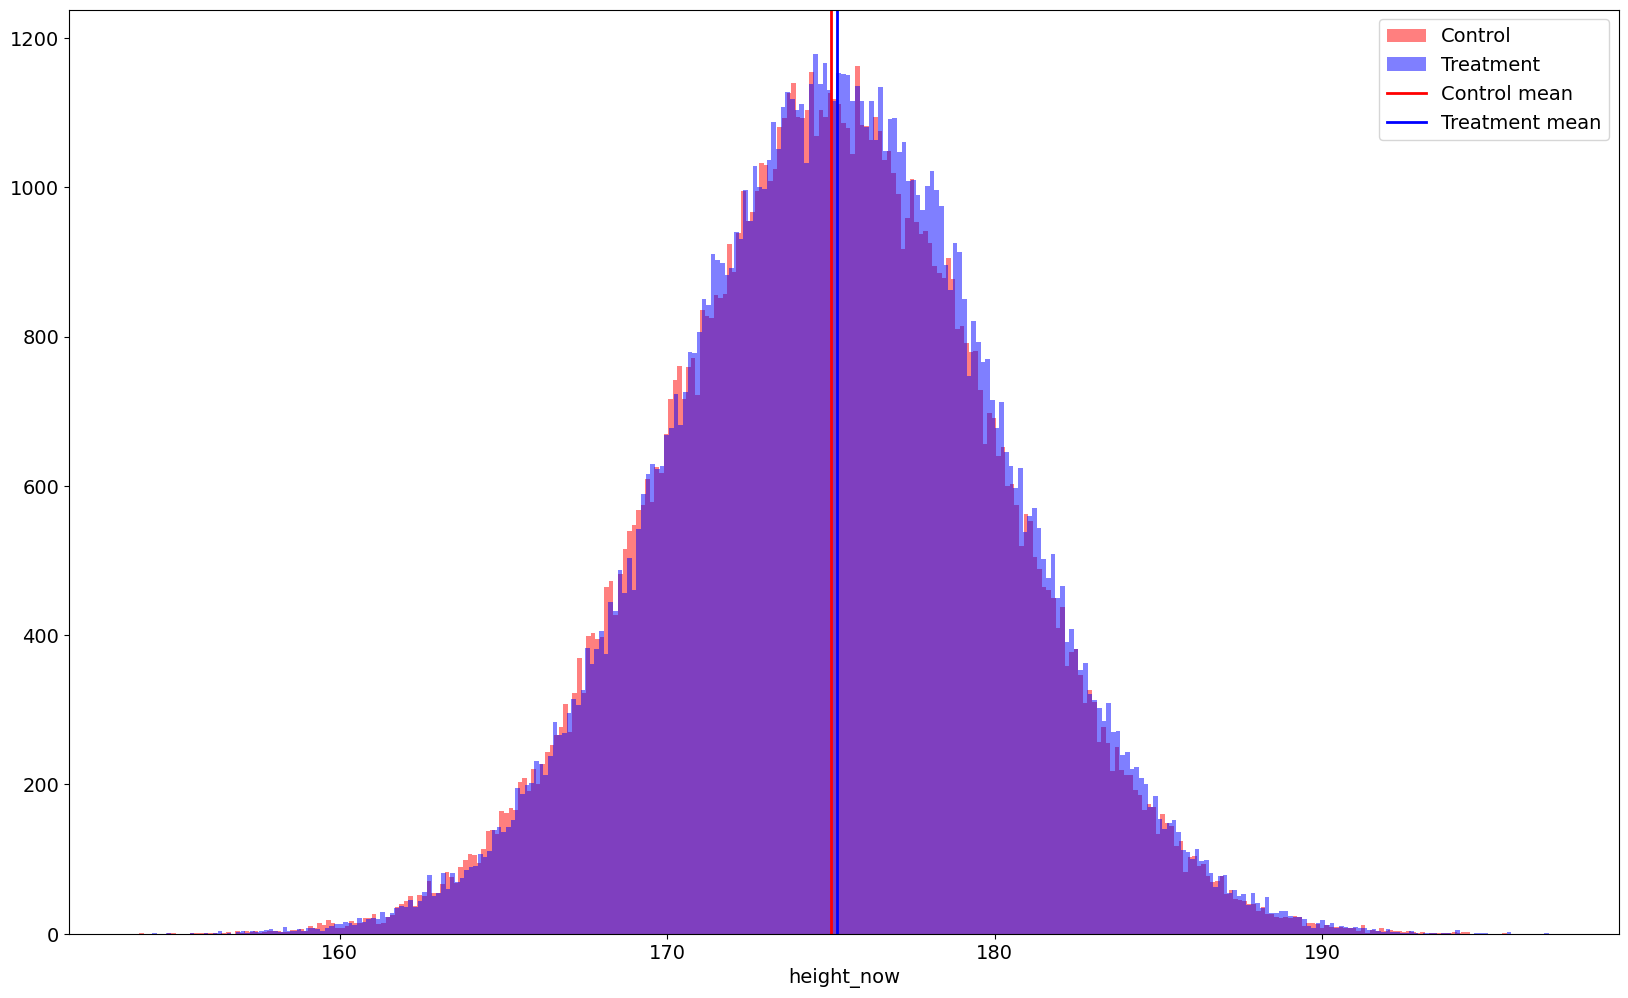

In [10]:
ab_test.plot()

## Кейс №1.1. Постанализ непрерывной метрики с бакетированием.

In [12]:
df = pd.read_csv('./data/ab_data.csv')
df['height_now'] = np.random.lognormal(1, 0.5, df.shape[0])

In [13]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    target='height_now', 
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    metric_type='continuous', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=100, 
    n_buckets=500
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [14]:
ab_test = ABTest(df, ab_params)
print(ab_test.test_welch())

{'stat': 0.07095900488038664, 'p-value': 0.9434304535289937, 'result': 0}


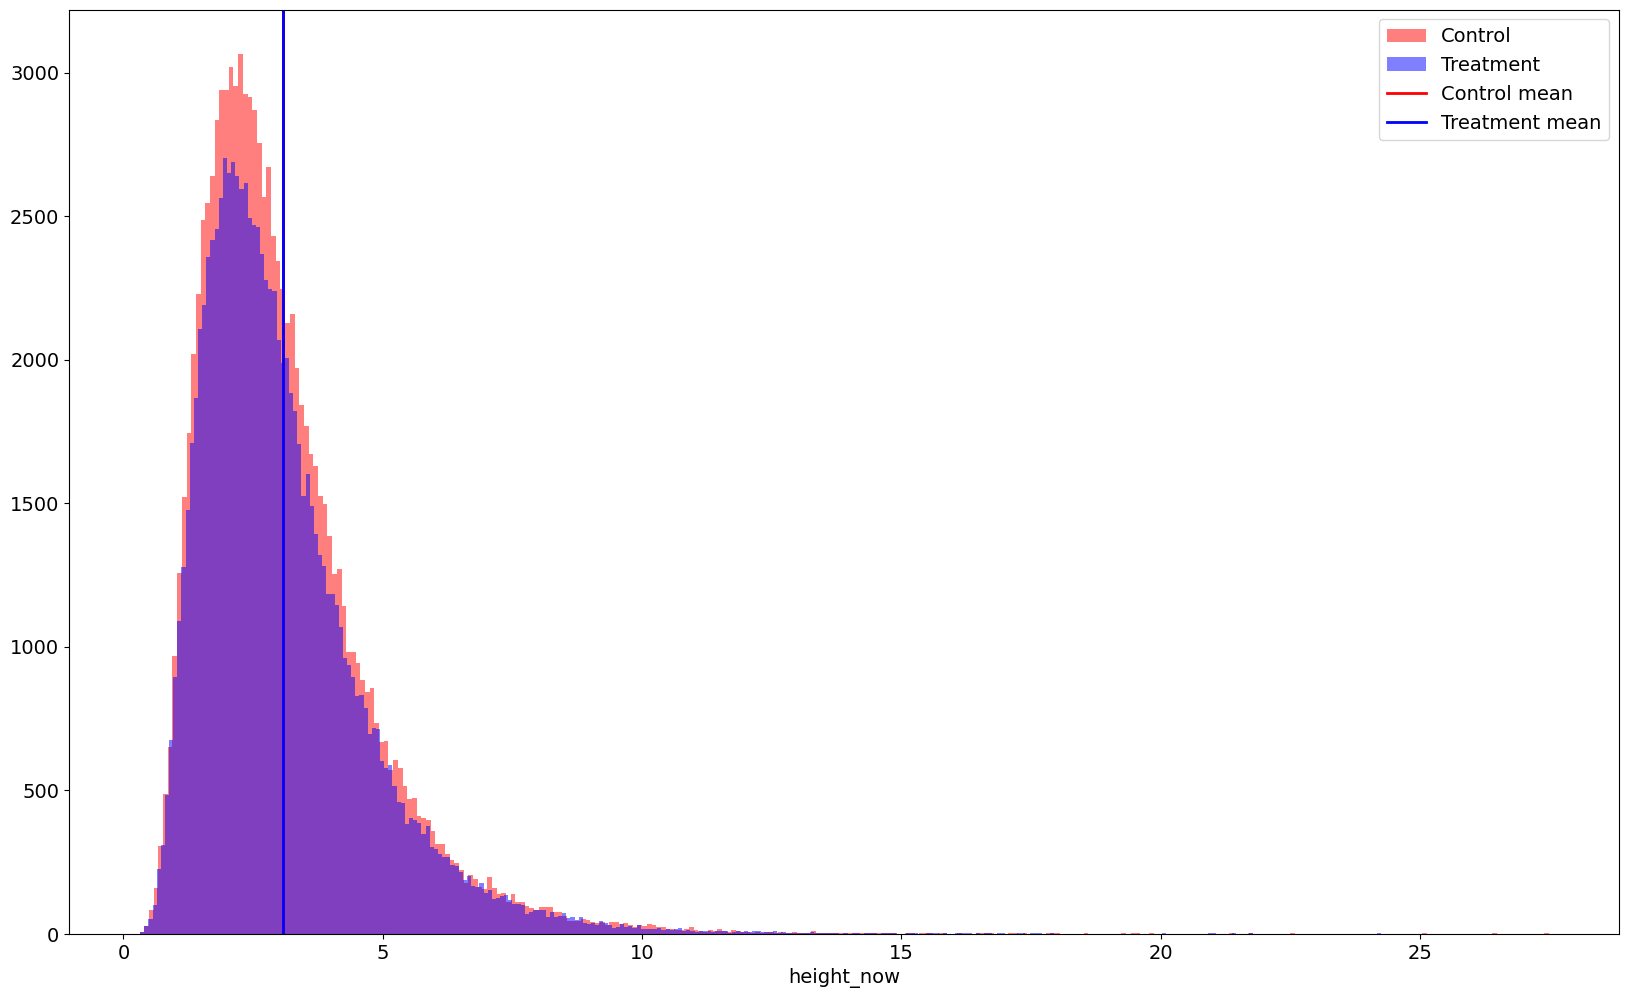

In [15]:
ab_test.plot()

In [16]:
print(len(ab_test.params.data_params.control))

99684


In [17]:
ab_test_11 = ab_test.bucketing()
print(len(ab_test_11.params.data_params.control))

500


In [18]:
print(ab_test_11.test_welch())

{'stat': 0.07352530939698362, 'p-value': 0.9414028490721805, 'result': 0}


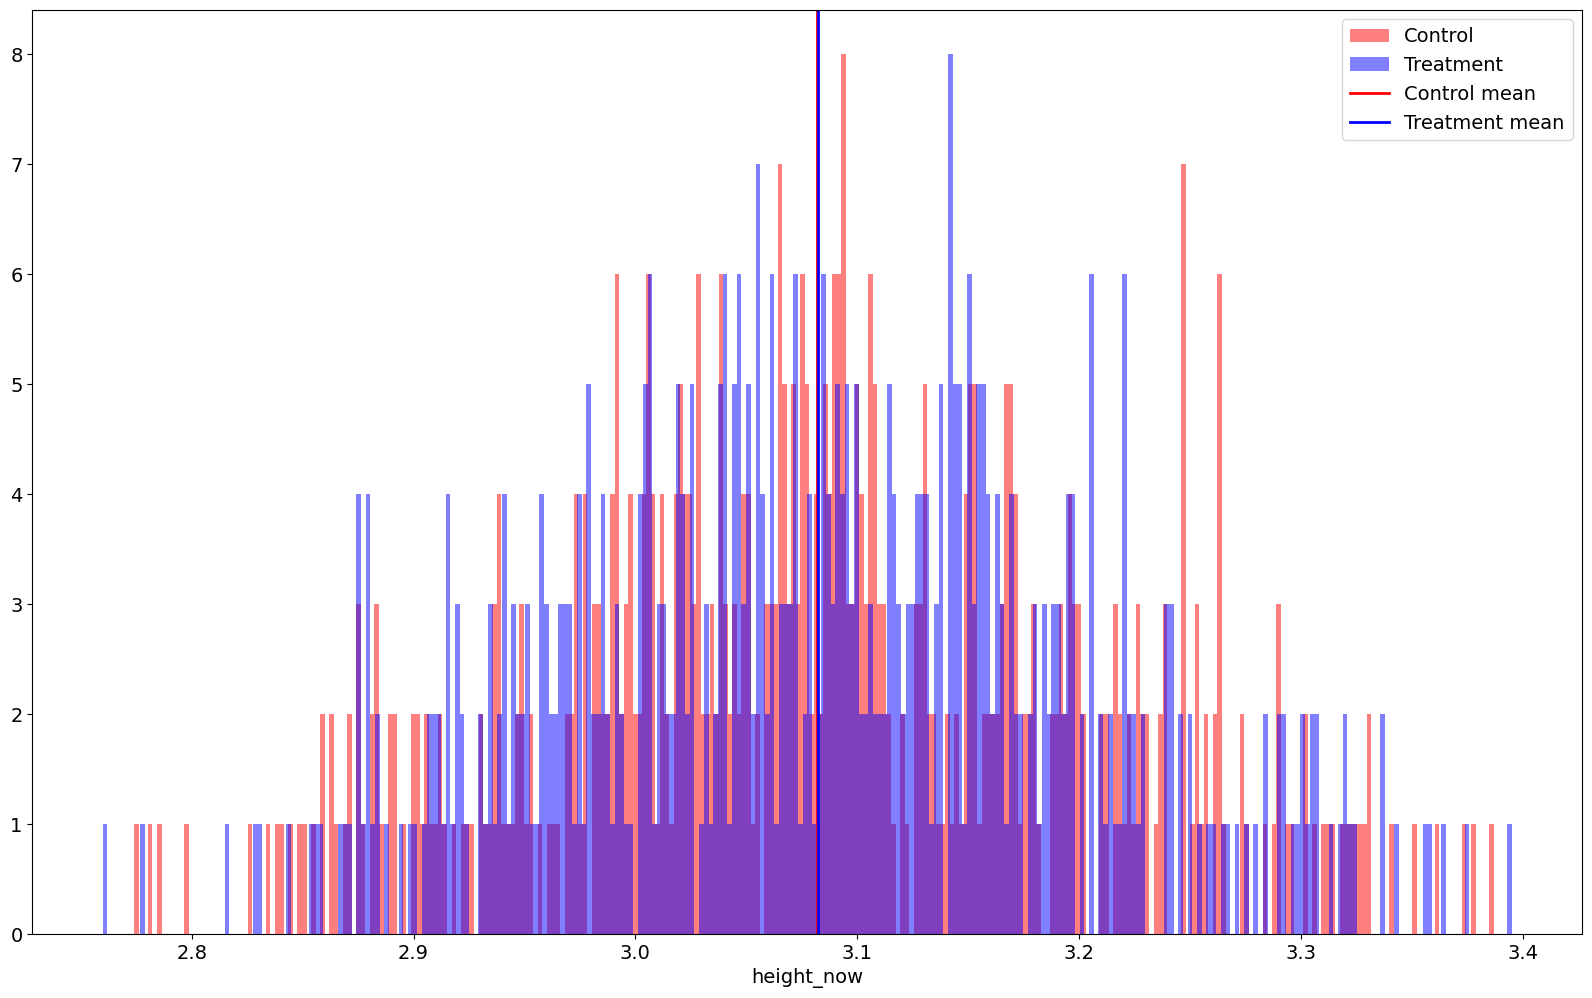

In [19]:
ab_test_11.plot()

In [20]:
scipy.stats.shapiro(ab_test_11.params.data_params.control)

ShapiroResult(statistic=0.9951373338699341, pvalue=0.11841655522584915)

# Кейс №2. Постанализ с увеличением чувствительности непрерывной метрики. CUPED.

In [21]:
df = pd.read_csv('./data/ab_data.csv')

In [22]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    strata_col='country', 
    target='height_now', 
    covariate='height_prev', 
    is_grouped=False
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    metric_type='continuous', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=100, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

Увеличиваем количество прокрасов в тестовой группе

In [23]:
df[ab_test.params.data_params.target].where(df[ab_test.params.data_params.group_col] == 'A',
                                            df[ab_test.params.data_params.target] * 1.0001, 
                                            axis=0,
                                            inplace=True)
df['id'] = np.random.randint(0, 150_000, df.shape[0])
df = df.drop_duplicates(['id'])

print('Без понижения дисперсии:')
ab_test = ABTest(df, ab_params)
print(f"bootstrap_test: {ab_test.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test.test_mannwhitney()}")
print(f"ttest_test: {ab_test.test_welch()}")

print('\nС понижением дисперсии:')
ab_test1 = ab_test.cuped()
print(f"bootstrap_test: {ab_test1.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test1.test_mannwhitney()}")
print(f"ttest_test: {ab_test1.test_welch()}")

Без понижения дисперсии:
bootstrap_test: {'stat': None, 'p-value': 0.815006322280991, 'result': 0}
mannwhitney_test: {'stat': 1519313534.0, 'p-value': 0.2783517888107635, 'result': 0}
ttest_test: {'stat': 0.8727577550733633, 'p-value': 0.38279702749761446, 'result': 0}

С понижением дисперсии:
bootstrap_test: {'stat': None, 'p-value': 0.9856995893636921, 'result': 1}
mannwhitney_test: {'stat': 1515118555.0, 'p-value': 0.06069118905071812, 'result': 0}
ttest_test: {'stat': 2.358589918992833, 'p-value': 0.01834624664601911, 'result': 1}


# Кейс №3. Постанализ для бинарной метрики.

In [24]:
df = pd.read_csv('./data/ab_data.csv')
df.head()

,height_now,height_prev,weight_now,weight_prev,noise_now,noise_prev,groups,id,moda_city,country,numerator,denominator,conversion
0,172.470442,166.382868,163.648256,173.422115,5.644384,-1.923929,A,0,3,2,3,2,1
1,178.610565,173.386388,173.195935,180.831845,11.664751,2.711829,B,1,2,2,1,4,1
2,180.382301,178.563579,174.520065,181.571024,7.183178,-0.453939,A,2,3,1,2,2,1
3,180.954018,179.732080,175.731245,182.840388,-4.682656,6.358723,B,3,4,1,3,2,0
4,167.590042,167.684244,166.109779,170.189261,9.134517,-1.153977,B,4,2,1,3,2,1


In [25]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    control_name='A',
    treatment_name='B',
    target_flg='conversion',  
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    metric_type='binary', 
    metric_name='mean', 
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [26]:
ab_test = ABTest(df, ab_params)

In [27]:
print('Нет эффекта:')
print(f"z_proportions_test: {ab_test.test_z_proportions()}")

Нет эффекта:
z_proportions_test: {'stat': 0.6730634505952151, 'p-value': 0.500906925062246, 'result': 0}


Увеличиваем количество прокрасов в тестовой группе

In [28]:
df['conversion'] = np.where(df.noise_now < 0, 0, 1)
df[ab_test.params.data_params.target_flg].where(df[ab_test.params.data_params.group_col] == 'A',
                                            np.random.binomial(n=1, p=0.72, size=df.shape[0]),
                                            axis=0,
                                            inplace=True)

ab_test = ABTest(df, ab_params)

print('Есть эффект:')
print(f"z_proportions_test: {ab_test.test_z_proportions()}")

Есть эффект:
z_proportions_test: {'stat': -140.44846376905068, 'p-value': 0.0, 'result': 1}


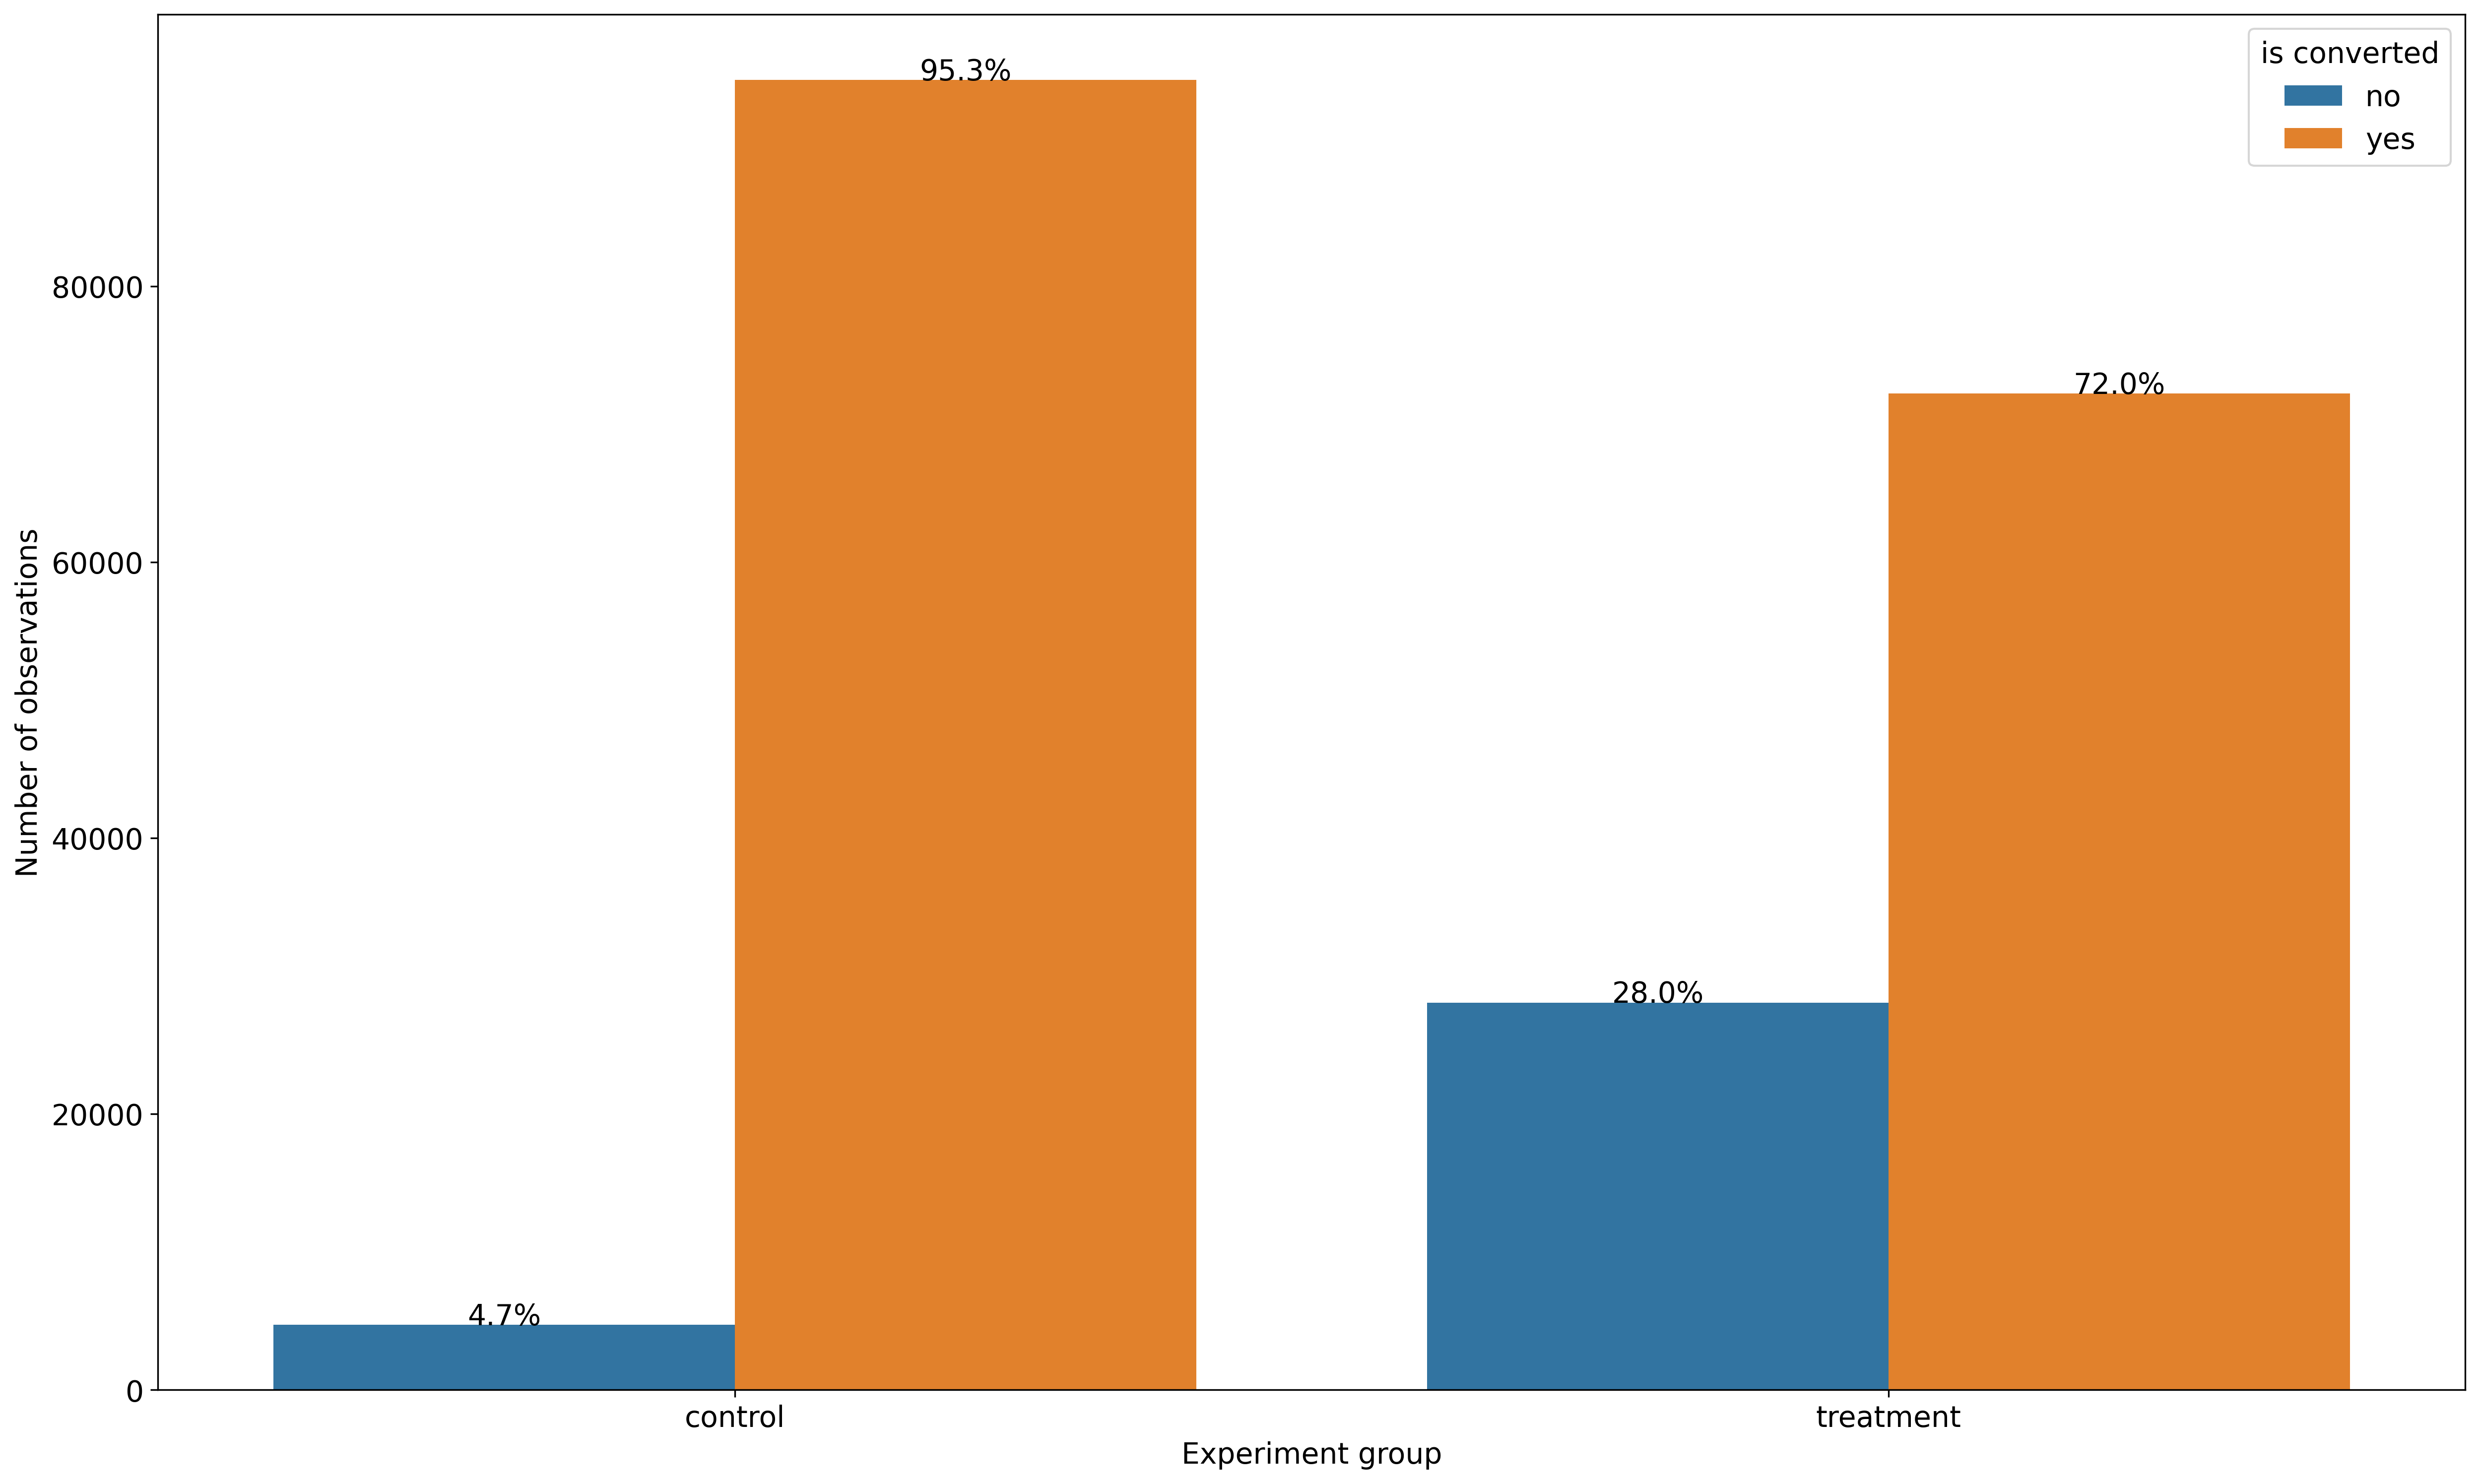

In [30]:
ab_test.plot()

# Кейс №4 — исключен

# Кейс №5. CUPED.
## Кейс №5.1. Различий между групп нет.

In [31]:
df = pd.read_csv('./data/ab_data.csv')

In [32]:
data_params = DataParams(
    id_col='id', 
    target='height_now', 
    covariate='height_prev', 
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided',  
    metric_type='continuous', 
    metric_name='mean',
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [33]:
ab_test = ABTest(df, ab_params)

In [34]:
print('Control mean = {:.3f}'.format(np.mean(ab_test.params.data_params.control)))
print('Treatment mean = {:.3f}'.format(np.mean(ab_test.params.data_params.treatment)))
print('Control var = {:.3f}'.format(np.var(ab_test.params.data_params.control)))
print('Treatment var = {:.3f}'.format(np.var(ab_test.params.data_params.treatment)))

Control mean = 174.990
Treatment mean = 175.000
Control var = 24.972
Treatment var = 24.900


In [35]:
print('Различий нет:')
print(f"bootstrap_test: {ab_test.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test.test_mannwhitney()}")
print(f"ttest_test: {ab_test.test_welch()}")

Различий нет:
bootstrap_test: {'stat': None, 'p-value': 0.6858825169033596, 'result': 0}
mannwhitney_test: {'stat': 4992976857.0, 'p-value': 0.5890975776571467, 'result': 0}
ttest_test: {'stat': 0.4435517988023507, 'p-value': 0.6573671411499618, 'result': 0}


Применяем CUPED:

In [36]:
ab_test1 = ab_test.cuped()

In [37]:
print('Control mean = {:.3f}'.format(np.mean(ab_test1.params.data_params.control)))
print('Treatment mean = {:.3f}'.format(np.mean(ab_test1.params.data_params.treatment)))
print('Control var = {:.3f}'.format(np.var(ab_test1.params.data_params.control)))
print('Treatment var = {:.3f}'.format(np.var(ab_test1.params.data_params.treatment)))

Control mean = 174.990
Treatment mean = 175.000
Control var = 3.417
Treatment var = 3.428


In [38]:
print('Если различий нет, то CUPED и не поможет их найти:')
print(f"bootstrap_test: {ab_test1.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test1.test_mannwhitney()}")
print(f"ttest_test: {ab_test1.test_welch()}")

Если различий нет, то CUPED и не поможет их найти:
bootstrap_test: {'stat': None, 'p-value': 0.89602664868682, 'result': 0}
mannwhitney_test: {'stat': 4989318477.0, 'p-value': 0.4102113130399977, 'result': 0}
ttest_test: {'stat': 1.1972717593974995, 'p-value': 0.23120206712777439, 'result': 0}


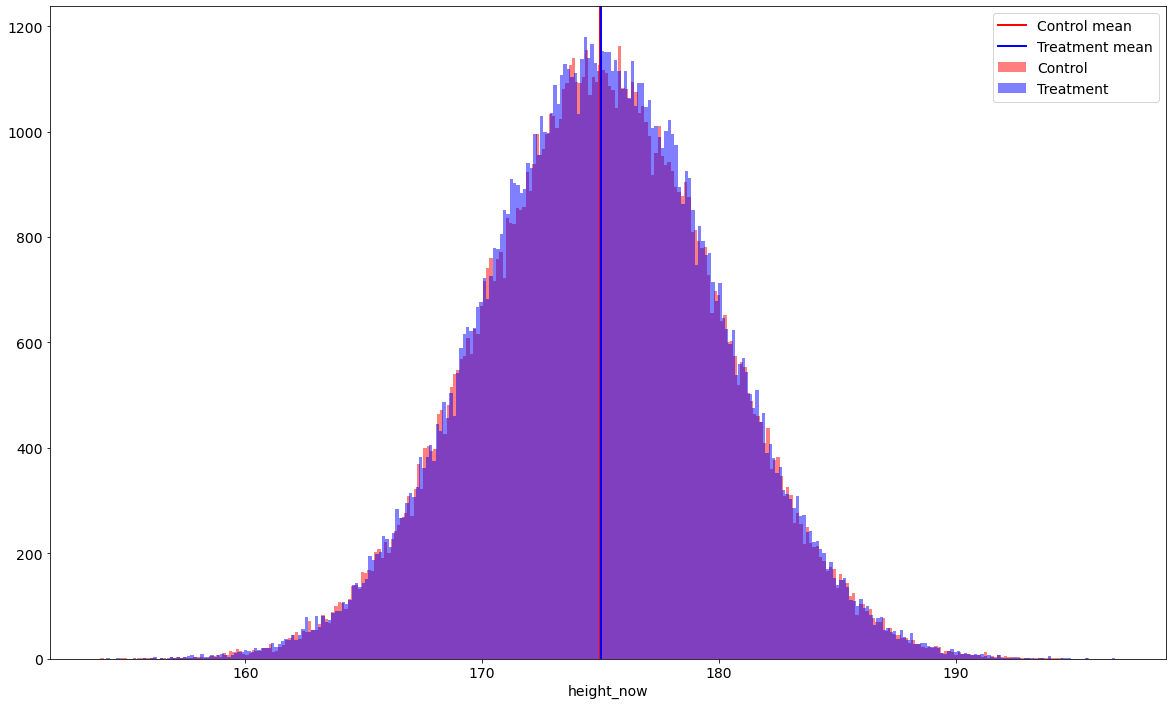

In [67]:
ab_test.plot()

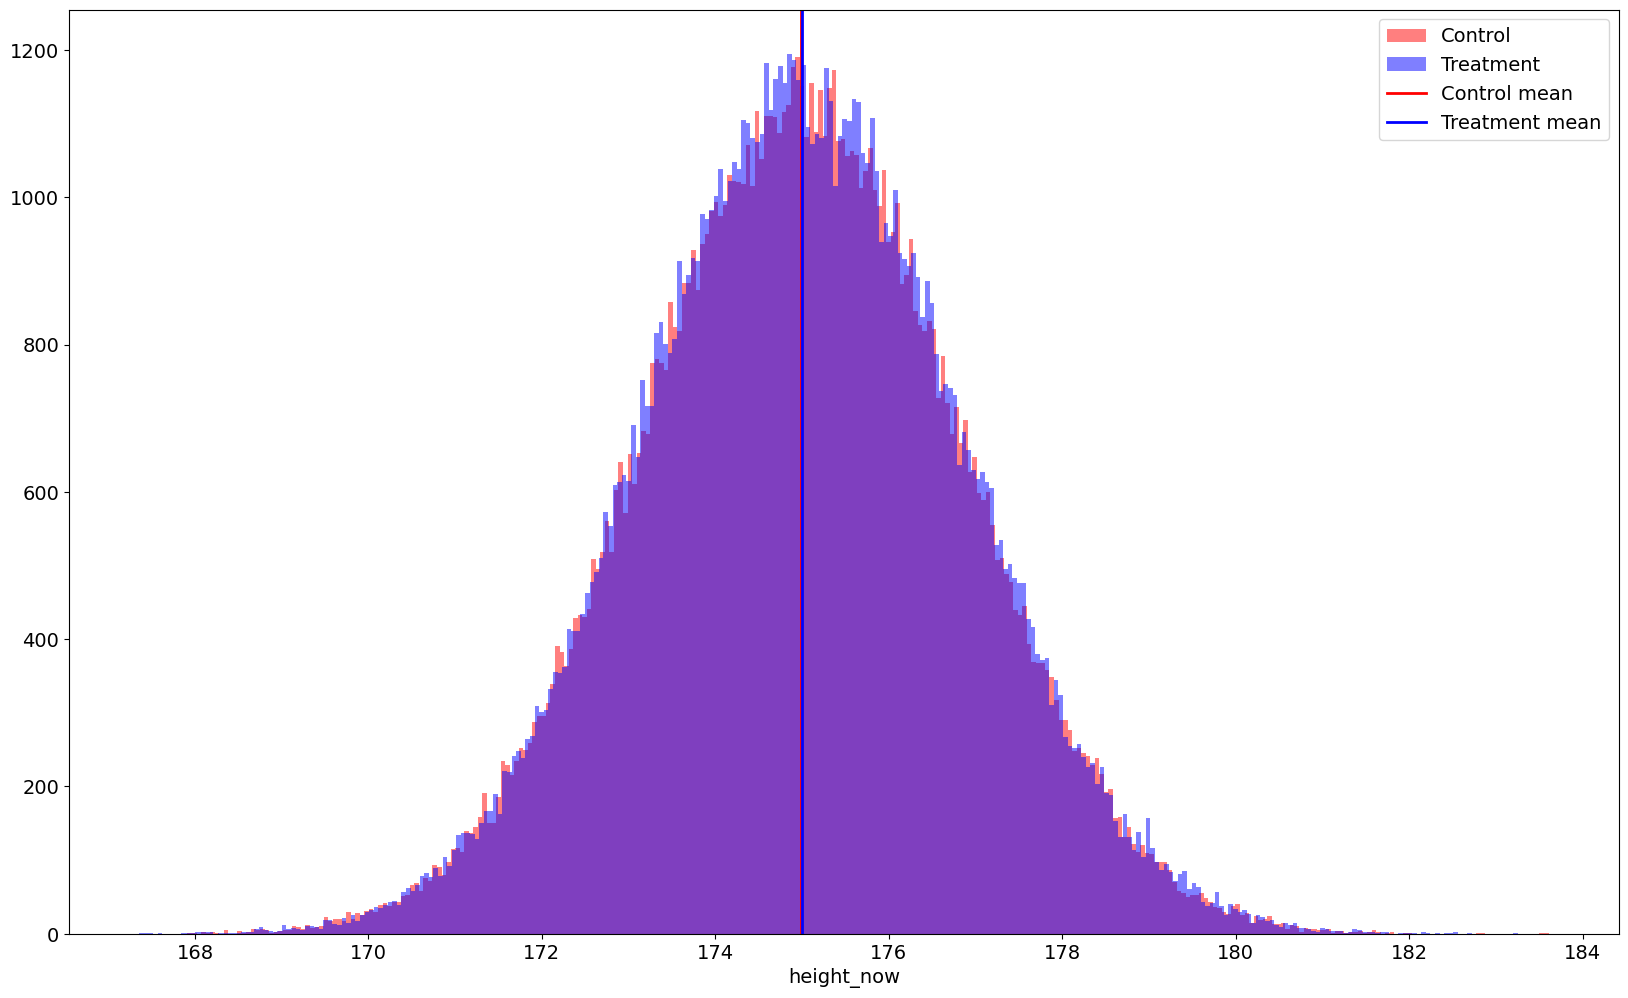

In [39]:
ab_test1.plot()

## Кейс №5.2. Различия между группами есть.

### Увеличиваем значения одной из групп.

In [40]:
df = pd.read_csv('./data/ab_data.csv')

incs = np.random.uniform(0.0, 0.009, df.shape[0])
df['height_now'].where(df[ab_test.params.data_params.group_col]=='A',
                                    df['height_now'] + incs, 
                                    axis=0,
                                    inplace=True)

In [41]:
data_params = DataParams(
    id_col='id', 
    group_col='groups',  
    target='height_now', 
    covariate='height_prev', 
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='greater', 
    metric_type='continuous', 
    metric_name='mean', 
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [42]:
incs = np.sort(np.random.uniform(0.0, 2, df.shape[0]))
df[ab_test.params.data_params.target].where(df[ab_test.params.data_params.group_col]=='A',
                                    df[ab_test.params.data_params.target] + incs, 
                                    axis=0,
                                    inplace=True)

In [43]:
ab_test = ABTest(df, ab_params)

In [44]:
print('Control mean = {:.3f}'.format(np.mean(ab_test.params.data_params.control)))
print('Treatment mean = {:.3f}'.format(np.mean(ab_test.params.data_params.treatment)))
print('Control var = {:.3f}'.format(np.var(ab_test.params.data_params.control)))
print('Treatment var = {:.3f}'.format(np.var(ab_test.params.data_params.treatment)))

Control mean = 174.990
Treatment mean = 176.004
Control var = 24.972
Treatment var = 25.254


In [45]:
print('Различий нет:\n')

print(f"bootstrap_test: {ab_test.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test.test_mannwhitney()}")
print(f"ttest_test: {ab_test.test_welch()}")

Различий нет:

bootstrap_test: {'stat': None, 'p-value': 1.0, 'result': 1}
mannwhitney_test: {'stat': 4429397676.0, 'p-value': 1.0, 'result': 0}
ttest_test: {'stat': 45.25361583804428, 'p-value': 0.0, 'result': 1}


Применяем CUPED:

In [46]:
ab_test2 = ab_test.cuped()

In [47]:
print('Control mean = {:.3f}'.format(np.mean(ab_test2.params.data_params.control)))
print('Treatment mean = {:.3f}'.format(np.mean(ab_test2.params.data_params.treatment)))
print('Control var = {:.3f}'.format(np.var(ab_test2.params.data_params.control)))
print('Treatment var = {:.3f}'.format(np.var(ab_test2.params.data_params.treatment)))

Control mean = 174.990
Treatment mean = 176.004
Control var = 3.417
Treatment var = 3.761


In [48]:
print('Если различия есть, то CUPED может помочь их найти:\n')

print(f"bootstrap_test: {ab_test2.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test2.test_mannwhitney()}")
print(f"ttest_test: {ab_test2.test_welch()}")

Если различия есть, то CUPED может помочь их найти:

bootstrap_test: {'stat': None, 'p-value': 1.0, 'result': 1}
mannwhitney_test: {'stat': 3528027530.0, 'p-value': 1.0, 'result': 0}
ttest_test: {'stat': 119.71315224347232, 'p-value': 0.0, 'result': 1}


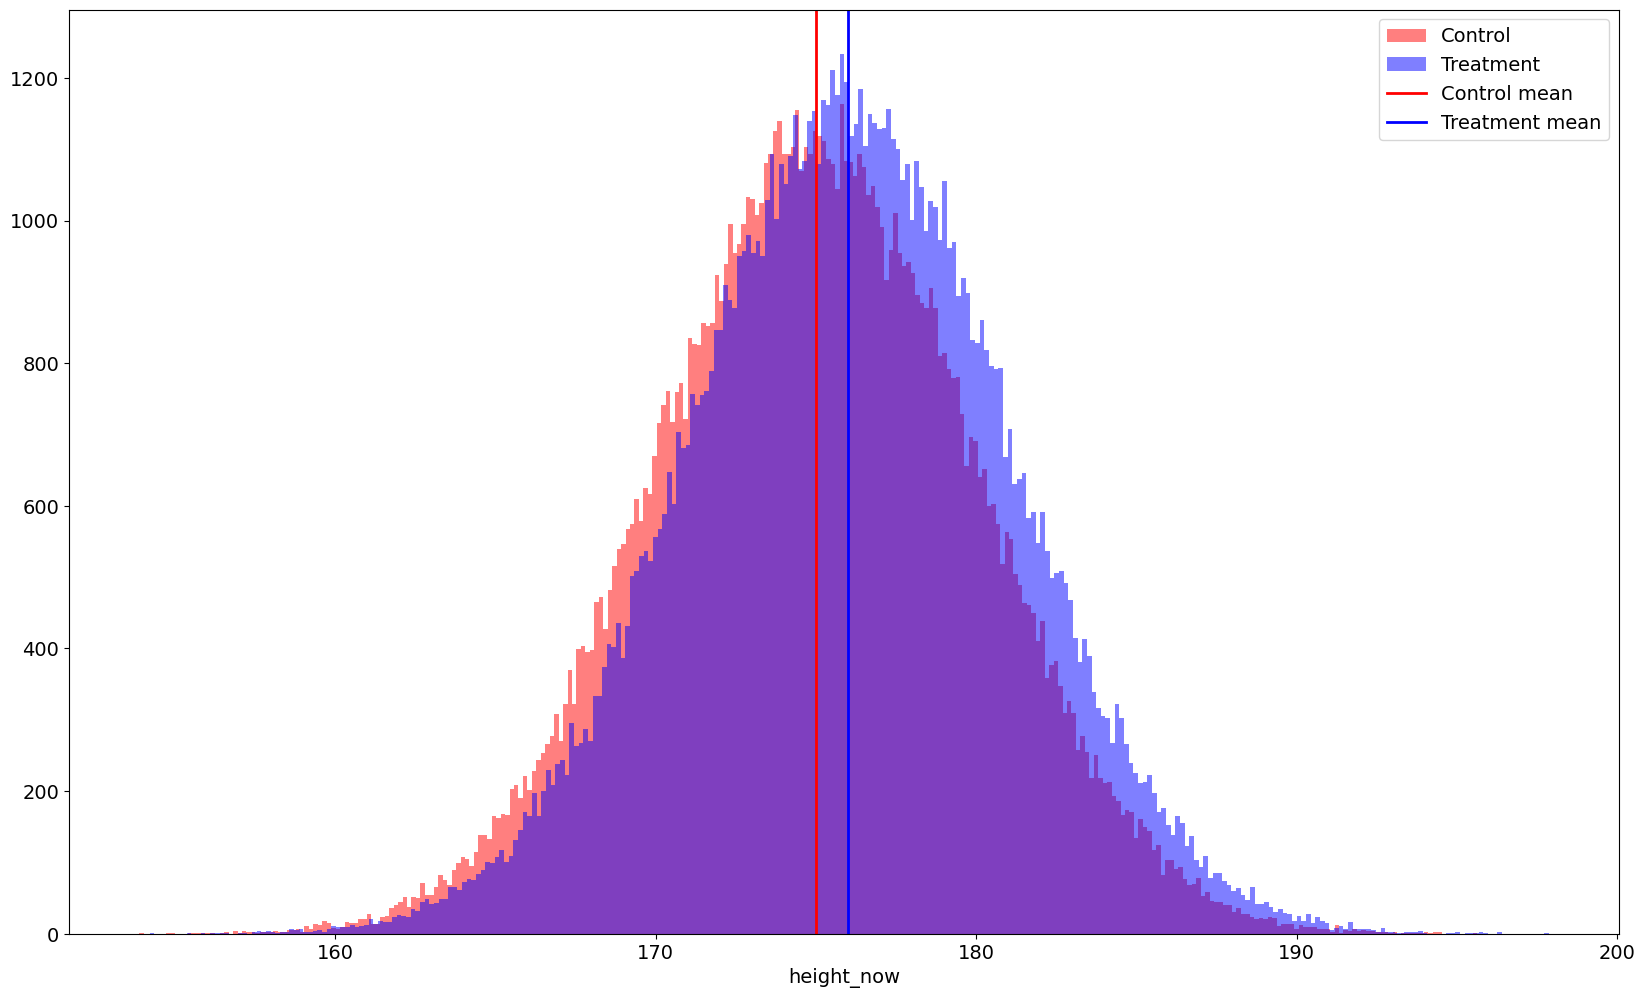

In [49]:
ab_test.plot()

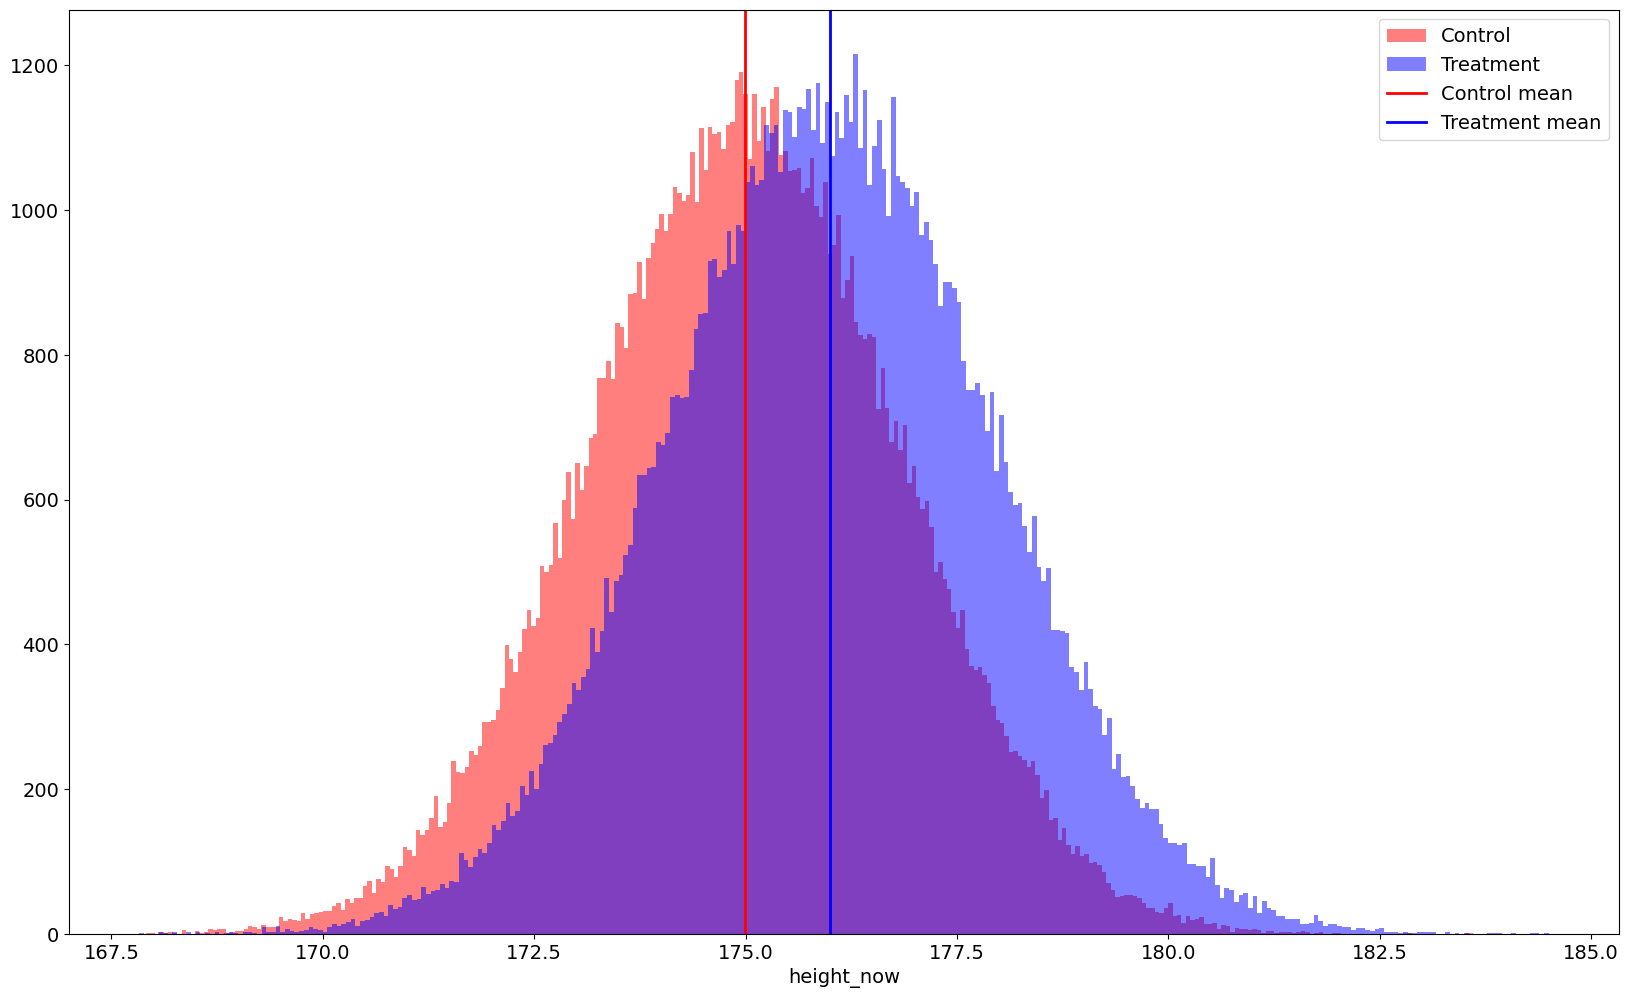

In [50]:
ab_test2.plot()

# Кейс №6. Всё вместе: chaining rule & reporting.

In [51]:
df = pd.read_csv('./data/ab_data.csv')
df.head()

,height_now,height_prev,weight_now,weight_prev,noise_now,noise_prev,groups,id,moda_city,country,numerator,denominator,conversion
0,172.470442,166.382868,163.648256,173.422115,5.644384,-1.923929,A,0,3,2,3,2,1
1,178.610565,173.386388,173.195935,180.831845,11.664751,2.711829,B,1,2,2,1,4,1
2,180.382301,178.563579,174.520065,181.571024,7.183178,-0.453939,A,2,3,1,2,2,1
3,180.954018,179.732080,175.731245,182.840388,-4.682656,6.358723,B,3,4,1,3,2,0
4,167.590042,167.684244,166.109779,170.189261,9.134517,-1.153977,B,4,2,1,3,2,1


In [52]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    target='height_now', 
    covariate='height_prev', 
    is_grouped=False
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    metric_type='continuous', 
    metric_name='mean', 
    n_boot_samples=100, 
    n_buckets=2000
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [53]:
df = pd.read_csv('./data/ab_data.csv')
df['height_now'].where(df['groups'] == 'A',
                       df['height_now'] * 1.003,
                       axis=0,
                       inplace=True)
df['id'] = np.random.randint(0, 150_000, df.shape[0])
df = df.drop_duplicates(['id'])

In [56]:
ab_test = ABTest(df, ab_params).linearization().cuped().bucketing()
ab_test.params.data_params.transforms

array(['linearization', 'cuped', 'bucketing'], dtype='<U32')

In [57]:
ab_test.test_welch()

{'stat': 48.39095387115231, 'p-value': 0.0, 'result': 1}

In [58]:
ab_test.report()


Parameters of experiment:
- Metric type: continuous.
- Metric: mean.
- Errors: alpha = 0.05, beta = 0.2.
- Alternative: two-sided.

Control group:
- Observations: 2000
- Mean: 0.0000
- Median: -0.0017
- 25th quantile: -0.2422
- 75th quantile: 0.2308
- Minimum: -1.2693
- Maximum: 1.2043
- St.deviation: 0.3479
- Variance: 0.1210

Treatment group:
- Observations: 2000
- Mean: 0.5377
- Median: 0.5290
- 25th quantile: 0.2996
- 75th quantile: 0.7716
- Minimum: -0.5878
- Maximum: 1.6760
- St.deviation: 0.3479
- Variance: 0.1210

Transformations applied: linearization -> cuped -> bucketing.

Number of bootstrap iterations: 100.
Number of buckets: 2000.

Following statistical tests are used:
- Welch's t-test: 48.39, p-value = 0.0000, H0 is rejected.
- Mann Whitney's U-test: 555888.00, p-value = 0.0000, H0 is rejected.
- Bootstrap test: H0 is rejected.

All three stat. tests showed that H0 is rejected.
        


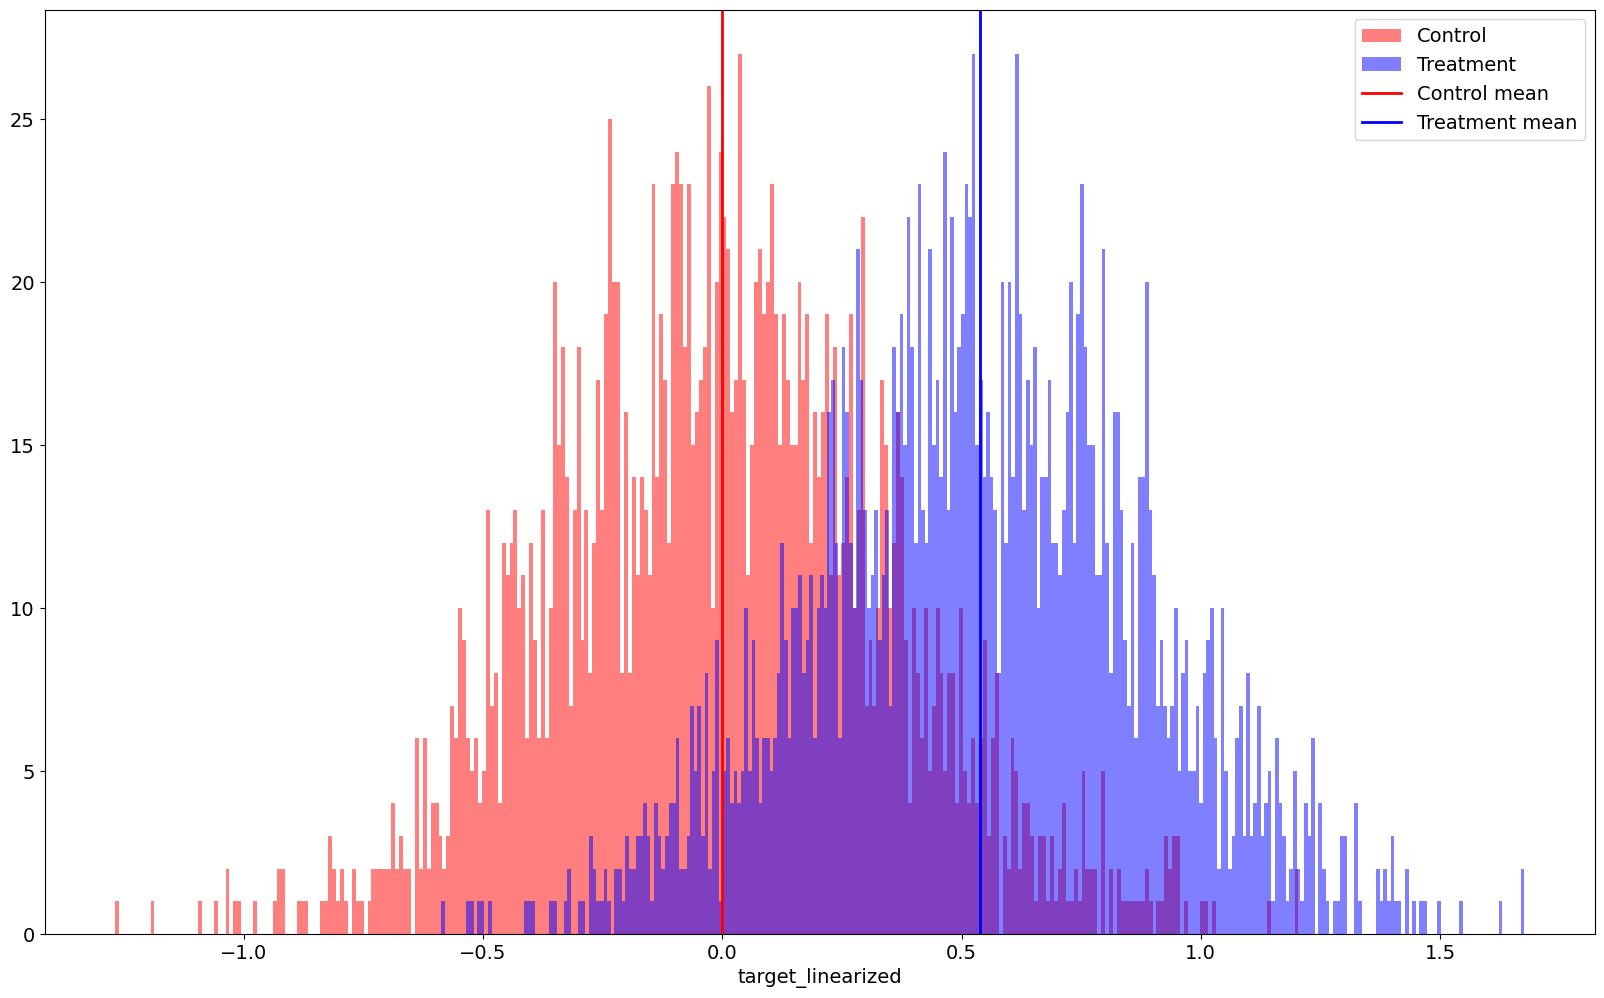

In [59]:
ab_test.plot()

# Кейс №7. Выделение групп.

In [60]:
df = pd.read_csv('./data/ab_data.csv', nrows=5000)

In [67]:
df["moda_city"] = np.random.randint(1, 5, df.shape[0])
df["moda_city"] = df["moda_city"].astype(str)
df["country"] = np.random.randint(1, 3, df.shape[0])
df["id"] = df.index

In [68]:
split_builder_params = SplitBuilderParams(
    map_group_names_to_sizes={
        'control': None,
        'target': None
    },
    main_strata_col = "moda_city",
    split_metric_col = "height_now",
    metric_type = "continuous",
    id_col = "id",
    cols = ["height_prev"],
    cat_cols=["country"],
    alpha=0.05,
    n_bins = 6,
    min_cluster_size = 100
)

In [69]:
split_builder = SplitBuilder(df, split_builder_params)

In [70]:
split = split_builder.collect()

SplitBuilderParams(map_group_names_to_sizes={'control': 2500, 'target': 2500}, main_strata_col='moda_city', split_metric_col='height_now', id_col='id', cols=['height_prev', 'height_now'], cat_cols=['country'], n_bins=6, min_cluster_size=100, strata_outliers_frac=0.01, alpha=0.05)


In [71]:
split.head()

,height_now,height_prev,weight_now,weight_prev,noise_now,noise_prev,groups,id,moda_city,country,numerator,denominator,conversion,strata,group_name
0,172.470442,166.382868,163.648256,173.422115,5.644384,-1.923929,A,0,2,0.503212,3,2,1,21-1,target
1,178.610565,173.386388,173.195935,180.831845,11.664751,2.711829,B,1,2,0.496816,1,4,1,24-1,target
2,180.382301,178.563579,174.520065,181.571024,7.183178,-0.453939,A,2,4,0.503212,2,2,1,45-1,control
3,180.954018,179.732080,175.731245,182.840388,-4.682656,6.358723,B,3,3,0.503212,3,2,0,35-1,control
4,167.590042,167.684244,166.109779,170.189261,9.134517,-1.153977,B,4,3,0.503212,3,2,1,30-1,target


# Кейс №8. Препилот для непрерывной метрики.

In [72]:
df = pd.read_csv('./data/ab_data.csv')
df = df.sample(n=20_000, random_state=1)

In [73]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    control_name='A',
    treatment_name='B', 
    target='height_now', 
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    metric_type='continuous',
    metric=np.mean, 
    n_boot_samples=100, 
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [74]:
experiment_params = MdeParams(
    metrics_names=['height_now'],
    injects=[1.0001,1.0002],
    min_group_size=5000, 
    max_group_size=10000, 
    step=2500,
    variance_reduction=None,
    use_buckets=False,
    stat_test=ABTest.test_boot_confint,
    iterations_number=10,
    max_beta_score=0.9,
    min_beta_score=0.02,
)

In [75]:
prepilot = MdeResearchBuilder(df, ab_params,
                                  experiment_params,
                                  split_builder_params)

In [76]:
beta, alpha = prepilot.collect()

In [77]:
beta

split_rate        (5000, 5000) (7500, 7500) (10000, 10000)
metric     Effect                                         
height_now 0.01%         >=0.9        >=0.9          >=0.9
           0.02%         >=0.9        >=0.9          >=0.9

In [78]:
alpha

split_rate,"(5000, 5000)","(7500, 7500)","(10000, 10000)"
metric,,,
height_now,0.0,0.0,0.0


# Кейс №9. Препилот для непрерывной метрики со снижением дисперсии.

In [79]:
df = pd.read_csv('./data/ab_data.csv')
df = df.sample(n=20_000, random_state=1)

In [80]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    control_name='A',
    treatment_name='B', 
    target='height_now', 
    covariate='height_prev',
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided',
    metric_type='continuous', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=200, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [81]:
prepilot_params = MdeParams(
    metrics_names=['height_now'],
    injects=[1.00046,1.00048,1.0005,1.001],
    min_group_size=5000, 
    max_group_size=10000, 
    step=1000,
    variance_reduction = ABTest.cuped,
    use_buckets = False,
    stat_test = ABTest.test_welch,
    iterations_number = 10,
    max_beta_score=0.9,
    min_beta_score=0.02,
)

In [82]:
split_builder_params = SplitBuilderParams(
    map_group_names_to_sizes={
        'control': None,
        'target': None
    },
    main_strata_col = "moda_city",
    split_metric_col = "height_now",
    metric_type = "continuous",
    id_col = "id",
    cols = ["height_prev"],
    cat_cols=["country"],
    alpha=0.05,
    n_bins = 6,
    min_cluster_size = 100
)

In [84]:
prepilot = MdeResearchBuilder(df, ab_params,
                                     prepilot_params,
                                     split_builder_params)

In [85]:
beta, alpha = prepilot.collect()

ERROR:abacus.splitter.split_builder:Could not split statistically target and control
ERROR:abacus.splitter.split_builder:Could not split statistically target and control


In [86]:
beta

split_rate        (5000, 5000) (6000, 6000) (7000, 7000) (8000, 8000)  \
metric     Effect                                                       
height_now 0.046%          0.6          0.5          0.3          0.1   
           0.048%          0.5          0.5          0.2          0.1   
           0.05%           0.3          0.4          0.1       <=0.02   
           0.1%         <=0.02       <=0.02       <=0.02       <=0.02   

split_rate        (9000, 9000) (10000, 10000)  
metric     Effect                              
height_now 0.046%       <=0.02         <=0.02  
           0.048%       <=0.02         <=0.02  
           0.05%        <=0.02         <=0.02  
           0.1%         <=0.02         <=0.02

In [87]:
alpha

split_rate,"(5000, 5000)","(6000, 6000)","(7000, 7000)","(8000, 8000)","(9000, 9000)","(10000, 10000)"
metric,,,,,,
height_now,0.0,0.0,0.0,0.0,0.0,0.0


# Кейс №10. Препилот для бинарной метрики.

In [98]:
df = pd.read_csv('./data/ab_data.csv')
df = df.sample(n=10_000, random_state=1)
df.head()

,height_now,height_prev,weight_now,weight_prev,noise_now,noise_prev,groups,id,moda_city,country,numerator,denominator,conversion
49673,176.962204,173.282588,168.286558,178.545051,8.332472,0.749710,B,49673,2,1,3,3,1
171551,167.719994,164.153443,159.805620,169.937810,6.185760,2.257602,A,171551,4,1,1,2,1
5506,173.478204,172.284449,168.578427,175.216619,7.729058,6.635701,B,5506,2,1,1,2,1
38370,174.789978,172.517970,168.646945,177.518410,9.830704,-1.382761,A,38370,3,1,4,3,1
36930,171.939344,172.241240,166.103368,175.124307,5.606161,6.901354,B,36930,4,2,4,3,1


In [99]:
data_params = DataParams(
    id_col='id', 
    group_col='groups',
    target_flg='conversion', 
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided',
    metric_type='binary', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=200, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [100]:
split_builder_params = SplitBuilderParams(
    map_group_names_to_sizes={
        'control': None,
        'target': None
    },
    main_strata_col = "moda_city",
    split_metric_col = "height_now",
    metric_type = "binary",
    id_col = "id",
    cols = ["height_prev"],
    cat_cols=["country"],
    alpha=0.05,
    n_bins = 6,
    min_cluster_size = 500
)

### Препилот без бакетирования

In [103]:
prepilot_params = MdeParams(
    metrics_names=['conversion'],
    injects=[1.001,1.005,1.01],
    min_group_size=2000, 
    max_group_size=5000, 
    step=1000,
    variance_reduction = None,
    use_buckets = False,
    stat_test = ABTest.test_z_proportions,
    iterations_number = 5,
    max_beta_score=0.9,
    min_beta_score=0.01,
)

prepilot = MdeResearchBuilder(df, ab_params,
                                  prepilot_params,
                                  split_builder_params)

In [104]:
%%time 
beta, alpha = prepilot.collect()

CPU times: user 828 ms, sys: 21.6 ms, total: 850 ms
Wall time: 849 ms


In [105]:
beta

split_rate        (2000, 2000) (3000, 3000) (4000, 4000) (5000, 5000)
metric     Effect                                                    
conversion 0.1%            0.8        >=0.9        >=0.9          0.8
           0.5%            0.8        >=0.9        >=0.9          0.4
           1.0%            0.6          0.8          0.6       <=0.01

In [106]:
alpha

split_rate,"(2000, 2000)","(3000, 3000)","(4000, 4000)","(5000, 5000)"
metric,,,,
conversion,0.2,0.2,0.0,0.2


# Кейс №11. Линеаризация

In [107]:
df = pd.read_csv('./data/ab_data.csv')
df.head()

,height_now,height_prev,weight_now,weight_prev,noise_now,noise_prev,groups,id,moda_city,country,numerator,denominator,conversion
0,172.470442,166.382868,163.648256,173.422115,5.644384,-1.923929,A,0,3,2,3,2,1
1,178.610565,173.386388,173.195935,180.831845,11.664751,2.711829,B,1,2,2,1,4,1
2,180.382301,178.563579,174.520065,181.571024,7.183178,-0.453939,A,2,3,1,2,2,1
3,180.954018,179.732080,175.731245,182.840388,-4.682656,6.358723,B,3,4,1,3,2,0
4,167.590042,167.684244,166.109779,170.189261,9.134517,-1.153977,B,4,2,1,3,2,1


In [125]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    control_name='A',
    treatment_name='B',
    numerator='numerator', 
    denominator='denominator', 
    covariate='height_prev',
    is_grouped=False
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    metric_type='ratio', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=200, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [126]:
ab_test = ABTest(df, ab_params)
ab_test_1 = ab_test.linearization()
ab_test_2 = ab_test_1.cuped()

In [129]:
df_linear = pd.DataFrame(data={
    'id': list(range(0, len(ab_test_1._ABTest__dataset.target_linearized), 1)),
    'ratio_linear': ab_test_1._ABTest__dataset.target_linearized
})

In [130]:
df_grouped = df.groupby(by=['id', 'groups'], 
                        as_index=False).agg({
                            'numerator': 'sum',
                            'denominator': 'sum'
                        })
df_grouped['ratio_real'] = df_grouped.numerator / df_grouped.denominator
df_grouped = df_grouped.merge(df_linear, how='left', on='id')
df_grouped.head()

,id,groups,numerator,denominator,ratio_real,ratio_linear
0,0,A,3,2,1.50,0.9978
1,1,B,1,4,0.25,-3.0044
2,2,A,2,2,1.00,-0.0022
3,3,B,3,2,1.50,0.9978
4,4,B,3,2,1.50,0.9978


In [131]:
df_grouped[['ratio_real', 'ratio_linear']].corr()

,ratio_real,ratio_linear
ratio_real,1.000000,0.901641
ratio_linear,0.901641,1.000000


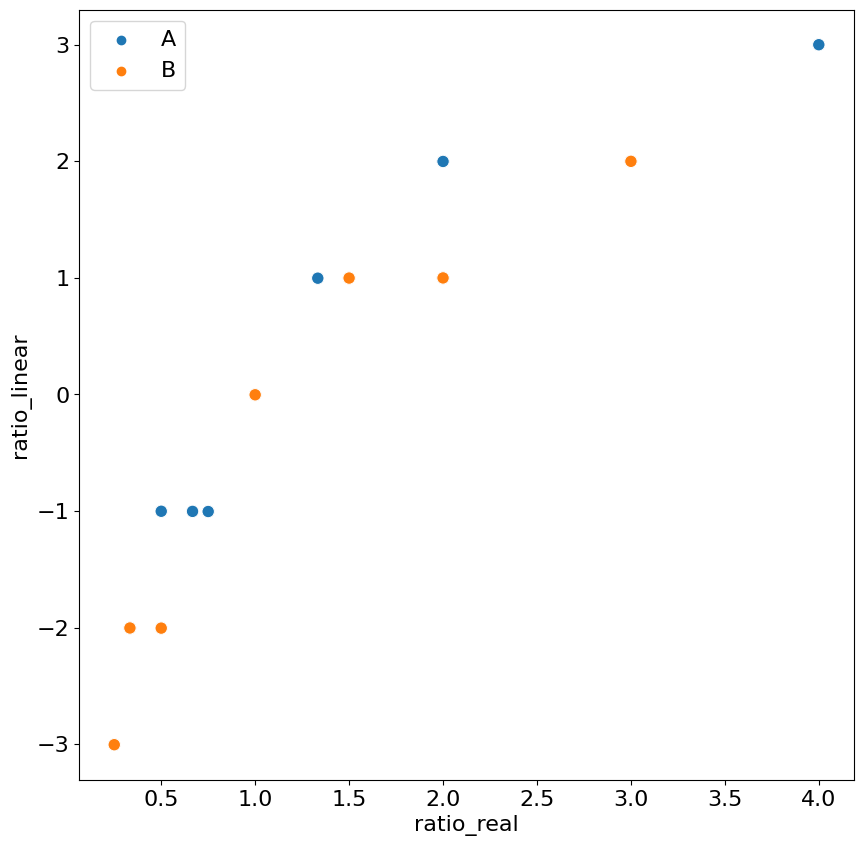

In [133]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_grouped,
            x='ratio_real', y='ratio_linear',
            hue='groups', s=80)
plt.legend()
plt.xlabel('ratio_real', fontsize=16)
plt.ylabel('ratio_linear', fontsize=16)
plt.show()
plt.close()

In [134]:
ab_test_1.params.data_params.transforms

array(['linearization'], dtype='<U32')

In [135]:
ab_test.params.data_params.transforms

[]

In [136]:
print(ab_test_2.report())


Parameters of experiment:
- Metric type: continuous.
- Metric: mean.
- Errors: alpha = 0.05, beta = 0.2.
- Alternative: two-sided.

Control group:
- Observations: 99684
- Mean: 0.0000
- Median: -0.0027
- 25th quantile: -1.0040
- 75th quantile: 0.9985
- Minimum: -3.0094
- Maximum: 3.0029
- St.deviation: 1.5810
- Variance: 2.4995

Treatment group:
- Observations: 100316
- Mean: 0.0011
- Median: -0.0027
- 25th quantile: -1.0039
- 75th quantile: 0.9985
- Minimum: -3.0093
- Maximum: 3.0033
- St.deviation: 1.5810
- Variance: 2.4995

Transformations applied: linearization -> cuped.

Number of bootstrap iterations: 200.

Following statistical tests are used:
- Welch's t-test: 0.15, p-value = 0.8786, H0 is not rejected.
- Mann Whitney's U-test: 4998264011.00, p-value = 0.8961, H0 is not rejected.
- Bootstrap test: H0 is not rejected.

All three stat. tests showed that H0 is not rejected.
        
None


# Кейс №11. Пайплайн как вызов цепочки методов

In [137]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    target='height_now', 
    covariate='height_prev', 
    is_grouped=False
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='greater', 
    metric_type='continuous', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=100, 
    n_buckets=2000
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [138]:
df = pd.read_csv('./data/ab_data.csv')
df['height_now'].where(df['groups'] == 'A',
                       df['height_now'] * 1.003,
                       axis=0,
                       inplace=True)
df['id'] = np.random.randint(0, 150_000, df.shape[0])
df = df.drop_duplicates(['id'])

In [139]:
ab_test = ABTest(df, ab_params).linearization().cuped().bucketing()

In [140]:
ab_test.params.data_params.transforms

array(['linearization', 'cuped', 'bucketing'], dtype='<U32')

In [141]:
ab_test.test_welch()

{'stat': 47.611745099088786, 'p-value': 0.0, 'result': 1}

In [142]:
ab_test.report()


Parameters of experiment:
- Metric type: continuous.
- Metric: mean.
- Errors: alpha = 0.05, beta = 0.2.
- Alternative: greater.

Control group:
- Observations: 2000
- Mean: -0.0001
- Median: 0.0001
- 25th quantile: -0.2309
- 75th quantile: 0.2219
- Minimum: -1.0865
- Maximum: 1.1186
- St.deviation: 0.3592
- Variance: 0.1290

Treatment group:
- Observations: 2000
- Mean: 0.5329
- Median: 0.5215
- 25th quantile: 0.2915
- 75th quantile: 0.7738
- Minimum: -0.6880
- Maximum: 1.8754
- St.deviation: 0.3592
- Variance: 0.1290

Transformations applied: linearization -> cuped -> bucketing.

Number of bootstrap iterations: 100.
Number of buckets: 2000.

Following statistical tests are used:
- Welch's t-test: 47.61, p-value = 0.0000, H0 is rejected.
- Mann Whitney's U-test: 573567.00, p-value = 1.0000, H0 is not rejected.
- Bootstrap test: H0 is rejected.

Two out of three stat. tests showed that H0 is rejected.
        


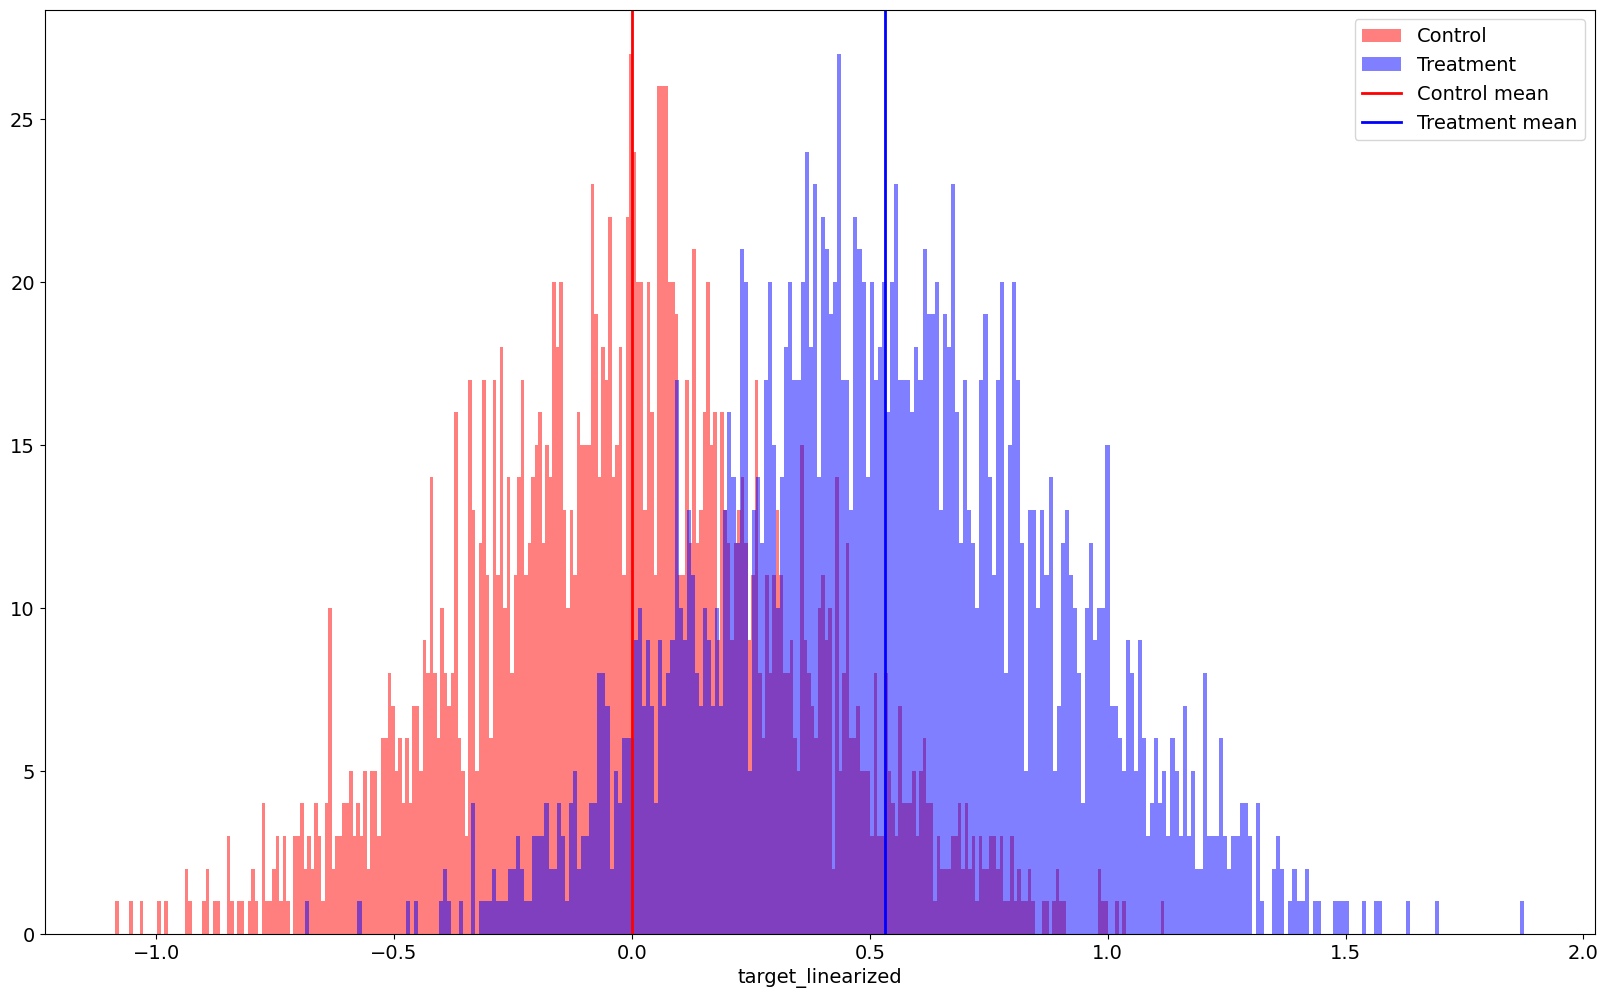

In [143]:
ab_test.plot()